In [2]:
!apt update
!apt install -y openjdk-17-jdk-headless
!pip install pathling==7.2.0 deltalake==0.25.4 pandas==2.2.2 polars==1.26.0

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
36 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InR

In [43]:
from pathling import PathlingContext

pc = PathlingContext.create(
    enable_extensions=True,
    enable_delta=True,
    enable_terminology=False,
)

In [76]:
from pathling import Expression as exp

import os
import json
from collections import defaultdict

### Load Patient Data
# Wir laden die einzelnen FHIR-Bundles und generieren daraus je ein ndsjon-File pro Ressourcen-Typ

# Vorher müssen die json-Files in den Ordner data/ hier in die Laufzeit hochgeladen werden!

input_folder = "./data"
output_folder = "./ndjson"
os.makedirs(output_folder, exist_ok=True)

resources_by_type = defaultdict(list)

for filename in os.listdir(input_folder):
    if not filename.endswith(".json"):
        continue
    filepath = os.path.join(input_folder, filename)
    with open(filepath, "r") as f:
        bundle = json.load(f)
        if bundle.get("resourceType") != "Bundle":
            print(f"{filename} ist kein Bundle, wird übersprungen.")
            continue

        entries = bundle.get("entry", [])
        for entry in entries:
            resource = entry.get("resource")
            if resource:
                rtype = resource.get("resourceType")
                if rtype:
                    resources_by_type[rtype].append(resource)

for rtype, resources in resources_by_type.items():
    output_path = os.path.join(output_folder, f"{rtype}.ndjson")
    with open(output_path, "w") as f_out:
        for res in resources:
            f_out.write(json.dumps(res) + "\n")

# Einlesen der ndjson-Files als Datenbasis
# Pathling erkennt automatisch anhand des Dateinamens, welche Resource jeweils enthalten ist, und stellt sie als verbundenes Datenmodell für spätere Abfragen bereit.

data = pc.read.ndjson("./ndjson/")

### Extract Patient Data

# Wir nutzen `reverseResolve`, um von der Patient-Resource auf die zugehörigen Diagnosen (`Condition`) zuzugreifen.

# Dabei extrahieren wir:
# - die Patienten-ID
# - das Geschlecht
# - das Geburtsdatum
# - den Diagnoseschlüssel (ICD 10)

result = data.extract(
    "Patient",
    columns=[
        exp("id", "patient_id"),
        exp("gender", "gender"),
        exp("birthDate", "birth_date"),
        exp("reverseResolve(Condition.subject).code.coding.where(system='http://fhir.de/CodeSystem/bfarm/icd-10-gm').code", "condition_code"),
    ],
)

result.show(truncate=False)

+----------------------------------------------------------------+------+----------+--------------+
|patient_id                                                      |gender|birth_date|condition_code|
+----------------------------------------------------------------+------+----------+--------------+
|17fd07c897c1b71242be625380c0f570dd1262c3e8e6716c09819705494d65b5|female|1980-01-01|NULL          |
|66eab990c3ab4a1dac96eecfa7189a4455b4a4e9d39b1813fa20e17b8cc564d2|male  |1951-10-15|C91.1         |
|1f3cbe89f02e77981b92928db4f8522ddd4be1d8d14a243e7fcc9834a0d35575|male  |1980-01-02|NULL          |
|23283daf4d699cc4b3e9d01cd4ce1344cd94f9f9769dfd88da68b2b696332d48|male  |1952-03-05|C61           |
|a02e16474896f1d528cac71f2c9b4c45ac3c9028e3a53fb414a1f7882991ee07|female|1950-05-01|C50.9         |
|a02e16474896f1d528cac71f2c9b4c45ac3c9028e3a53fb414a1f7882991ee07|female|1950-05-01|C50.9         |
|a02e16474896f1d528cac71f2c9b4c45ac3c9028e3a53fb414a1f7882991ee07|female|1950-05-01|C50.9         |


In [78]:
from pyspark.sql.functions import col

# Filtere beim Extrahieren nach bestimmten Diagnosen, z.B. C50 (Mammakarzinom):

mamma_patients = data.extract(
    "Patient",
    columns=[
        exp("id", "patient_id"),
        exp("birthDate", "birth_date"),
        exp("reverseResolve(Condition.subject).code.coding.where(system='http://fhir.de/CodeSystem/bfarm/icd-10-gm').code", "condition_code"),
    ],
).filter(col("condition_code").contains("C50"))

mamma_patients.show(truncate=False)

+----------------------------------------------------------------+----------+--------------+
|patient_id                                                      |birth_date|condition_code|
+----------------------------------------------------------------+----------+--------------+
|9142ee3ff7990f826ada966f03da267e0fe662f73858158f5e868b772cd68730|1950-10-15|C50.4         |
|a02e16474896f1d528cac71f2c9b4c45ac3c9028e3a53fb414a1f7882991ee07|1950-05-01|C50.9         |
|a02e16474896f1d528cac71f2c9b4c45ac3c9028e3a53fb414a1f7882991ee07|1950-05-01|C50.9         |
|a02e16474896f1d528cac71f2c9b4c45ac3c9028e3a53fb414a1f7882991ee07|1950-05-01|C50.9         |
|a02e16474896f1d528cac71f2c9b4c45ac3c9028e3a53fb414a1f7882991ee07|1950-05-01|C50.9         |
|a02e16474896f1d528cac71f2c9b4c45ac3c9028e3a53fb414a1f7882991ee07|1950-05-01|C50.9         |
|a02e16474896f1d528cac71f2c9b4c45ac3c9028e3a53fb414a1f7882991ee07|1950-05-01|C50.9         |
|a02e16474896f1d528cac71f2c9b4c45ac3c9028e3a53fb414a1f7882991ee07|1950

In [79]:
# Schreibe alle geladenen FHIR-Ressourcen als Delta Lake-Dateien in das Verzeichnis './delta'.
# Dabei wird jede Resource (z. B. Patient, Condition, Observation) als eigene Delta-Tabelle gespeichert.

data.write.delta("./delta")

In [88]:
from deltalake import DeltaTable

# Lade die 'Condition'-Tabelle aus dem Delta-Verzeichnis und wandle sie in ein Pandas DataFrame um.

dt = DeltaTable("./delta/Condition.parquet")
df = dt.to_pandas()
df_simple = df.drop(columns=["_extension"])
df_simple[["id", "code", "subject"]]

,id,code,subject
0,17bc83a84fc6d9a7f9df24684aae287df117609026a237...,"{'id': None, 'coding': [{'id': None, 'system':...","{'id': None, 'reference': 'Patient/4a8639bbad9..."
1,257c056341e9015dfdd7d15cab0a7414b348796b2b0181...,"{'id': None, 'coding': [{'id': None, 'system':...","{'id': None, 'reference': 'Patient/9142ee3ff79..."
2,413358315002752adf6281447c5ef51bc9e87334ca2c34...,"{'id': None, 'coding': [{'id': None, 'system':...","{'id': None, 'reference': 'Patient/66eab990c3a..."
3,5236d8328066567b90c671091d739dc044ae00f4f9e73a...,"{'id': None, 'coding': [{'id': None, 'system':...","{'id': None, 'reference': 'Patient/a02e1647489..."
4,781b35a7a67a782459e38993bcfcebb068ac97e8bdf214...,"{'id': None, 'coding': [{'id': None, 'system':...","{'id': None, 'reference': 'Patient/b7590139fce..."
5,864086c778055cfdcf52915c303af7bfa4941ae6f56fb9...,"{'id': None, 'coding': [{'id': None, 'system':...","{'id': None, 'reference': 'Patient/23283daf4d6..."
6,9896edd80f6833ea17fbb2c5ad5ca42caa1d02f41baea8...,"{'id': None, 'coding': [{'id': None, 'system':...","{'id': None, 'reference': 'Patient/a02e1647489..."
7,9b5cabc4facc22d2681d7b63c3986487f3646a7ad8c10f...,"{'id': None, 'coding': [{'id': None, 'system':...","{'id': None, 'reference': 'Patient/5098a39800d..."
8,a31f38c3b6c0d35e6f228a50ba288b814250c774b8dc89...,"{'id': None, 'coding': [{'id': None, 'system':...","{'id': None, 'reference': 'Patient/b7590139fce..."
9,a9b49e6ae910db956adf674338ec65dff97a2d4c07c1f0...,"{'id': None, 'coding': [{'id': None, 'system':...","{'id': None, 'reference': 'Patient/a02e1647489..."


In [96]:
import polars as pl

# Konvertiere das Pandas DataFrame in ein Polars DataFrame

pl_df = pl.from_dataframe(df_simple)

# 'code' ist ein verschachteltes Feld mit mehreren Unterfeldern wie 'coding' und 'text'.
# Mit .unnest("code") werden diese Unterfelder auf der obersten Ebene des DataFrames "ausgepackt".

pl_df.select("code").unnest("code")

_fid,coding,id,text
i64,list[struct[7]],null,null
379779450,"[{1715992077,""C20"",null,null,""http://fhir.de/CodeSystem/bfarm/icd-10-gm"",null,""2020""}]",null,null
708753427,"[{1576562349,""C50.4"",null,null,""http://fhir.de/CodeSystem/bfarm/icd-10-gm"",null,""2020""}]",null,null
1706917596,"[{583564188,""C91.1"",null,null,""http://fhir.de/CodeSystem/bfarm/icd-10-gm"",null,""2020""}]",null,null
1642904422,"[{994824596,""C20"",null,null,""http://fhir.de/CodeSystem/bfarm/icd-10-gm"",null,""2020""}]",null,null
36927084,"[{386082870,""C91.1"",null,null,""http://fhir.de/CodeSystem/bfarm/icd-10-gm"",null,""2017""}]",null,null
…,…,…,…
143522712,"[{30510943,""D06.9"",null,null,""http://fhir.de/CodeSystem/bfarm/icd-10-gm"",null,""2022""}]",null,null
596728250,"[{1384451631,""D06.9"",null,null,""http://fhir.de/CodeSystem/bfarm/icd-10-gm"",null,""2022""}]",null,null
1660557819,"[{1396404776,""C56"",null,null,""http://fhir.de/CodeSystem/bfarm/icd-10-gm"",null,""2017""}]",null,null


+----------+----+
|birth_date|age |
+----------+----+
|1953-07-21|71  |
|1948-03-05|77  |
|1951-10-15|73  |
|1980-01-02|45  |
|1950-05-01|75  |
|1950-05-01|75  |
|1950-05-01|75  |
|1950-05-01|75  |
|1952-03-05|73  |
|1969-06-01|55  |
|NULL      |NULL|
|1950-10-15|74  |
|1951-01-07|74  |
|1960-01-16|65  |
|1980-01-01|45  |
+----------+----+



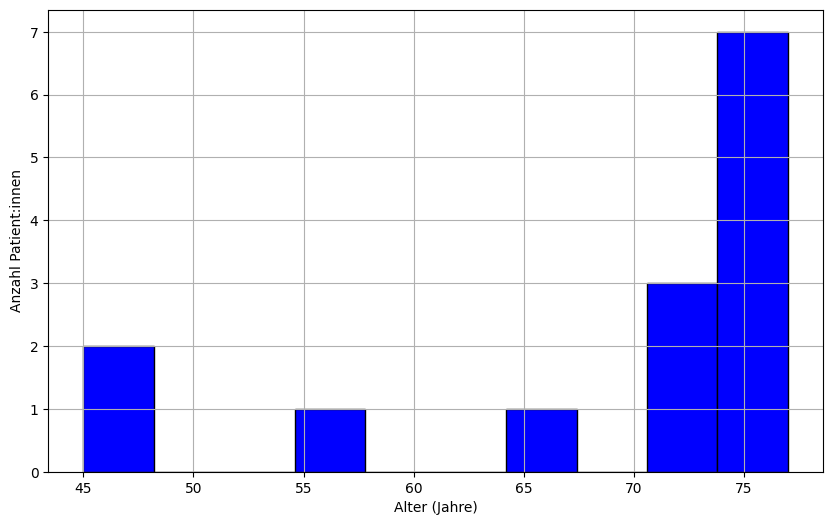

In [100]:
### AUFGABE 1 (Warm-Up): Altersverteilung der onkologischen Patient:innen


# 1.1 Extrahiere das Geburtsdatum aus den Daten der Patient:innen

patients = data.extract(
    "Patient",
    columns=[
        exp("birthDate", "birth_date"),
    ],
)

# 1.2 Berechne das Alter aus dem Geburtsdatum und füge es als neue Zeile in den DataFrame ein

from pyspark.sql.functions import col, current_date, datediff, floor, to_date

patients = patients.withColumn(
    "birth_date", to_date(col("birth_date"))
).withColumn(
    "age", floor(datediff(current_date(), col("birth_date")) / 365.25)
)

patients.select("birth_date", "age").show(truncate=False)

# 1.3 Daten in Pandas überführen

patients_pd = patients.toPandas()

# 1.4 Zeichne ein Histogramm der Altersverteilung

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(patients_pd["age"].dropna(), bins=10, edgecolor="black", color="blue")
plt.xlabel("Alter (Jahre)")
plt.ylabel("Anzahl Patient:innen")
plt.grid(True)
plt.show()
